In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle
import os
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
import cv2 as cv
import math
import time
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#https://www.tensorflow.org/lite/models/pose_estimation/overview
#https://programmer.group/analysis-of-official-post-energy-model-of-tensorflow.html

<p> For code i have refered from this links<br>

-https://www.tensorflow.org/lite/models/pose_estimation/overview<br>
-https://programmer.group/analysis-of-official-post-energy-model-of-tensorflow.html<br>
-https://medium.com/roonyx/pose-estimation-and-matching-with-tensorflow-lite-posenet-model-ea2e9249abbd  (code Referenced link)

In [2]:
model_path = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"

In [3]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [4]:
# Get input and output tensors information from the model file
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

In [5]:
output_details

[{'name': 'MobilenetV1/heatmap_2/BiasAdd',
  'index': 87,
  'shape': array([ 1,  9,  9, 17]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'MobilenetV1/offset_2/BiasAdd',
  'index': 90,
  'shape': array([ 1,  9,  9, 34]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'MobilenetV1/displacement_fwd_2/BiasAdd',
  'index': 84,
  'shape': array([ 1,  9,  9, 32]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'MobilenetV1/displacement_bwd_2/BiasAdd',
  'index': 81,
  'shape': array([ 1,  9,  9, 32]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [6]:
def model_output(path):
    '''
    Input: path of the image
    Output: HeatMap, Offsets'''
    template_image_src = cv.imread(path)
    template_image = cv.resize(template_image_src, (257, 257))
    template_input = np.expand_dims(template_image.copy(), axis=0)
    floating_model = input_details[0]['dtype'] == np.float32

    if floating_model:
        template_input = (np.float32(template_input) - 127.5) / 127.5
    # Process template image
    # Sets the value of the input tensor
    interpreter.set_tensor(input_details[0]['index'], template_input)
    # Runs the computation
    interpreter.invoke()
    # Extract output data from the interpreter
    template_output_data = interpreter.get_tensor(output_details[0]['index'])
    template_offset_data = interpreter.get_tensor(output_details[1]['index'])
    # Getting rid of the extra dimension
    template_heatmaps = np.squeeze(template_output_data)
    template_offsets = np.squeeze(template_offset_data)
    #print("template_heatmaps' shape:", template_heatmaps.shape)
    #print("template_offsets' shape:", template_offsets.shape)
    return template_heatmaps,template_offsets

In [7]:
def parse_output(heatmap_data,offset_data, threshold):

  '''
  Input:
    heatmap_data - hetmaps for an image. Three dimension array
    offset_data - offset vectors for an image. Three dimension array
    threshold - probability threshold for the keypoints. Scalar value
  Output:
    array with coordinates of the keypoints and flags for those that have
    low probability
  COnd: If nose and (any one eye) and (any one hip) and (any one ankle) is present then only Bool will be True
  '''

  joint_num = heatmap_data.shape[-1]
  pose_kps = np.zeros((joint_num,3), np.uint32)

  for i in range(heatmap_data.shape[-1]):

      joint_heatmap = heatmap_data[...,i]
      max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
      remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
      pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
      pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
      max_prob = np.max(joint_heatmap)

      if max_prob > threshold:
        if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
          pose_kps[i,2] = 1
      bool = (pose_kps[0][2]==1) and ((pose_kps[1][2] or pose_kps[2][2]) ==1) and ((pose_kps[11][2] or pose_kps[12][2]) ==1) and ((pose_kps[15][2] or pose_kps[16][2]) ==1)
  return bool

In [8]:
'''dic ={0:'nose',
1:'leftEye',
2:'rightEye',
3:'leftEar',
4:'rightEar',
5:'leftShoulder',
6:'rightShoulder',
7:'leftElbow',
8:'rightElbow',
9:'leftWrist',
10:'rightWrist',
11:'leftHip',
12:'rightHip',
13:'leftKnee',
14:'rightKnee',
15:'leftAnkle',
16:'rightAnkle',}'''

"dic ={0:'nose',\n1:'leftEye',\n2:'rightEye',\n3:'leftEar',\n4:'rightEar',\n5:'leftShoulder',\n6:'rightShoulder',\n7:'leftElbow',\n8:'rightElbow',\n9:'leftWrist',\n10:'rightWrist',\n11:'leftHip',\n12:'rightHip',\n13:'leftKnee',\n14:'rightKnee',\n15:'leftAnkle',\n16:'rightAnkle',}"

In [9]:
def final(path):
    '''
    Input: path of the Image 
    output: Bool true or flase 
    Explanation : it takes path and it sends to model to get the 
    output and it sends to parse output function to get wheater it is a full pose or not'''
    
    template_heatmaps,template_offsets = model_output(path)
    bool = parse_output(template_heatmaps,template_offsets,0.5)
    return bool

In [10]:
print(final(path='D:\Appliedaicourse\Casestudy2\data\women_shirts_tops_tees\\image10_4.jpg'))

True


In [11]:
def final_custom(path):
    '''
    Input: path of Image
    ouutpu: fullpose or not And Image
    This function plot with wheater it is a fullpose image or not and it will plot image also
    '''
    bool = final(path)
    if bool:
        print("Full Pose Image")
        image=cv.imread(path)
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.show()
        print("\n")
    else:
        print("Not Full-Pose-Image")
        image=cv.imread(path)
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.show()
        print("\n")

In [18]:
import cv2

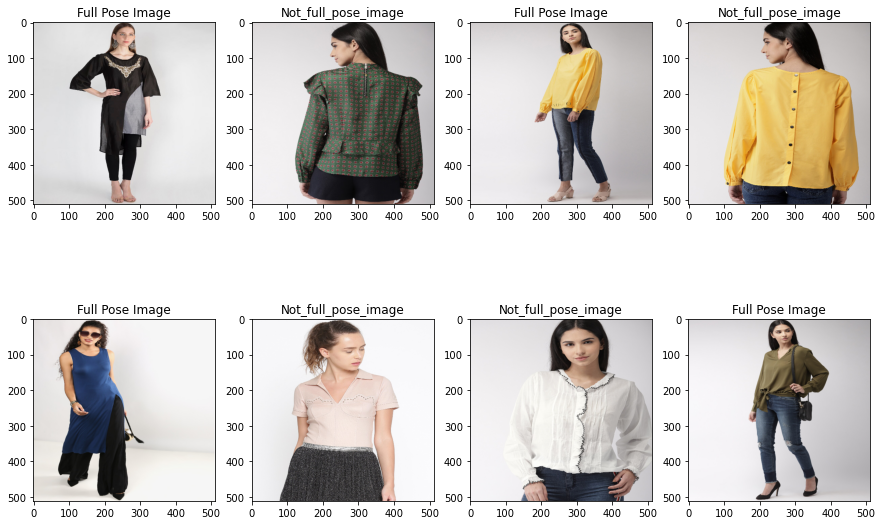

Time taken : 2.549750804901123


In [32]:
start=time.time()
path='D:\Appliedaicourse\Casestudy2\data\women_shirts_tops_tees\\'
w=10
h=10
fig = plt.figure(figsize=(15,10))
columns = 4
rows = 2
image =['image0_0.jpg ','image2_3.jpg','image4_4.jpg','image4_3.jpg','image44_1.jpg','image7_0.jpg','image9_0.jpg','image17_4.jpg']
for i in range(len(image)):
    
    pa = os.path.join(path,image[i])
    if final(pa):
        im = cv.imread(pa)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv.resize(im,(512,512))
        fig.add_subplot(rows,columns,i+1)
        plt.imshow(im)
        plt.title("Full Pose Image")
    else:
        im = cv.imread(pa)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv.resize(im,(512,512))
        fig.add_subplot(rows,columns,i+1)
        
        plt.imshow(im)
        plt.title('Not_full_pose_image')
plt.show()
end = time.time()
print("Time taken : {}".format(end-start))

Not Full-Pose-Image


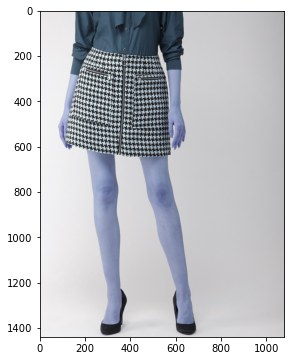



Full Pose Image


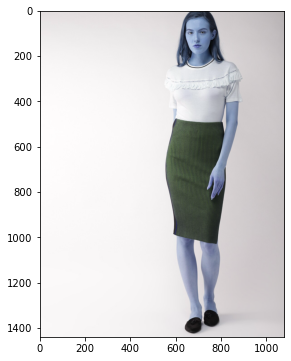



Full Pose Image


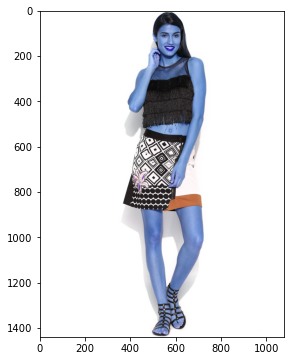



Not Full-Pose-Image


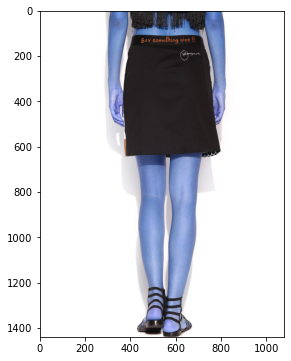



Full Pose Image


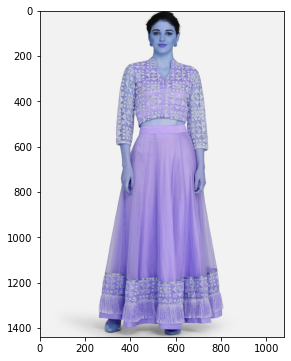



Not Full-Pose-Image


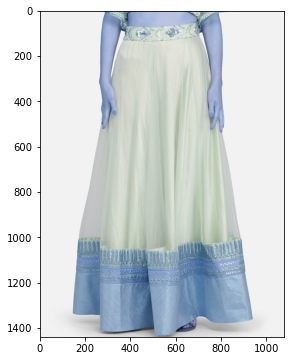



Not Full-Pose-Image


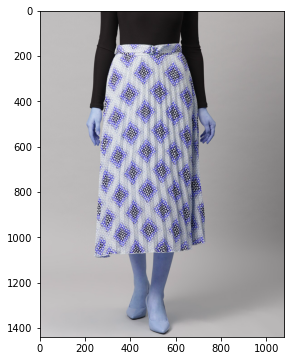



Time taken : 3.4294466972351074


In [12]:
start=time.time()
path='D:\Appliedaicourse\Casestudy2\data\women_shorts_skirts\\'
image =['image0_0.jpg ','image2_3.jpg','image4_4.jpg','image4_3.jpg','image8_3.jpg','image7_0.jpg','image9_0.jpg']
for i in image:
    pa = os.path.join(path,i)
    final_custom(pa)
end = time.time()
print("Time taken : {}".format(end-start))

Not Full-Pose-Image


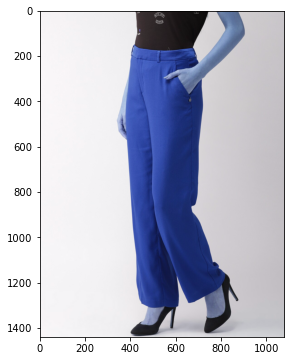



Full Pose Image


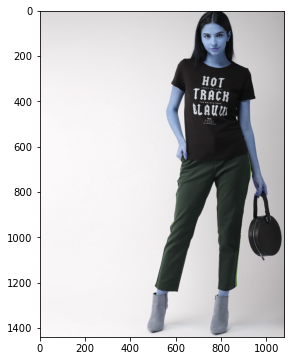



Not Full-Pose-Image


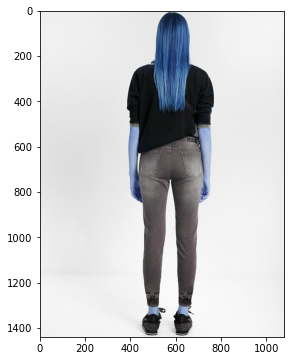



Full Pose Image


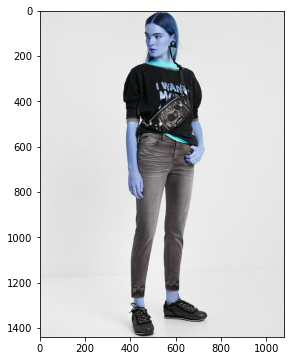



Not Full-Pose-Image


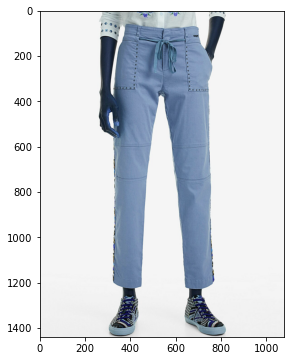



Not Full-Pose-Image


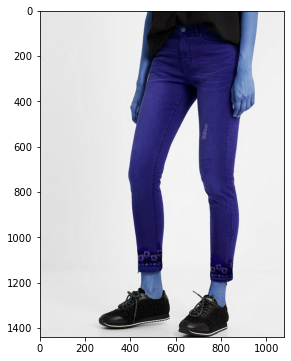



Not Full-Pose-Image


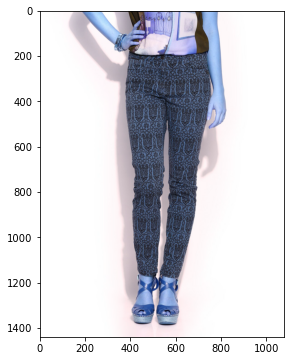



Time taken : 3.47259521484375


In [13]:
start=time.time()
path='D:\Appliedaicourse\Casestudy2\data\women_trousers'
image =['image0_0.jpg ','image2_3.jpg','image4_4.jpg','image4_3.jpg','image8_3.jpg','image7_0.jpg','image9_0.jpg']
for i in image:
    pa = os.path.join(path,i)
    final_custom(pa)
end = time.time()
print("Time taken : {}".format(end-start))

## Now Getting All the full_shot pose images from folders

In [15]:
def full_image_path(path):
    path_list = []
    for i in tqdm(os.listdir(path)):
        #print(path,i)
        if i.split('.')[1] == 'jpg':
            #print(os.path.join(path,i))
            bool=final(os.path.join(path,i))
            if bool==True:
                path_list.append(os.path.join(path,i))
    return path_list

In [16]:
boot_path = full_image_path('data\women_boots')

100%|██████████████████████████████████████████████████████████████████████████████| 6273/6273 [13:44<00:00,  7.61it/s]


In [17]:
women_casual_shoes = full_image_path('data\women_casual_shoes')

100%|██████████████████████████████████████████████████████████████████████████████| 9279/9279 [23:09<00:00,  6.68it/s]


In [18]:
women_flats = full_image_path('data\women_flats')

100%|████████████████████████████████████████████████████████████████████████████| 13683/13683 [37:12<00:00,  6.13it/s]


In [19]:
women_heels = full_image_path('data\women_heels')

100%|████████████████████████████████████████████████████████████████████████████| 15021/15021 [45:47<00:00,  5.47it/s]


In [20]:
women_jeans_jeggings = full_image_path('data\women_jeans_jeggings')

100%|██████████████████████████████████████████████████████████████████████████████| 4199/4199 [15:07<00:00,  4.63it/s]


In [21]:
women_shirts_tops_tees = full_image_path('data\women_shirts_tops_tees')

100%|██████████████████████████████████████████████████████████████████████████| 20011/20011 [1:02:49<00:00,  5.31it/s]


In [22]:
women_shorts_skirts = full_image_path('data\women_shorts_skirts')

100%|██████████████████████████████████████████████████████████████████████████████| 5965/5965 [14:28<00:00,  6.87it/s]


In [23]:
women_trousers = full_image_path('data\women_trousers')

100%|████████████████████████████████████████████████████████████████████████████| 16085/16085 [38:16<00:00,  7.00it/s]


In [42]:
import pickle
pickle.dump(boot_path,open('boot_path.pkl','wb'))
pickle.dump(women_casual_shoes,open('women_casual_shoes.pkl','wb'))
pickle.dump(women_flats,open('women_flats.pkl','wb'))
pickle.dump(women_heels,open('women_heels.pkl','wb'))
pickle.dump(women_jeans_jeggings,open('women_jeans_jeggings.pkl','wb'))
pickle.dump(women_shirts_tops_tees,open('women_shirts_tops_tees.pkl','wb'))
pickle.dump(women_shorts_skirts,open('women_shorts_skirts.pkl','wb'))
pickle.dump(women_trousers,open('women_trousers.pkl','wb'))

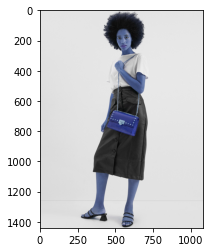

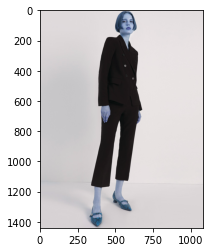

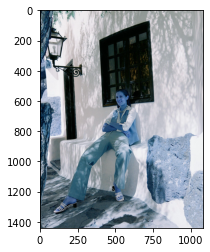

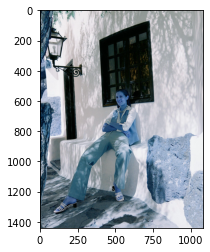

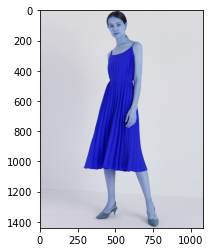

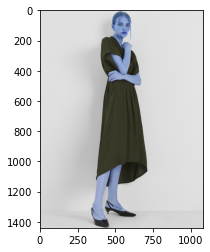

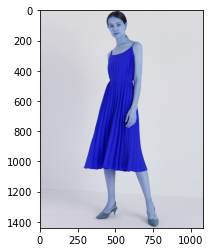

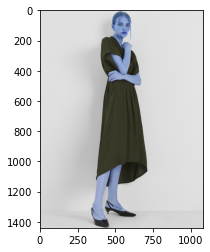

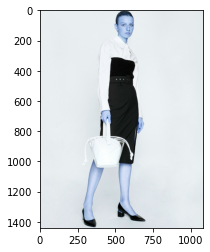

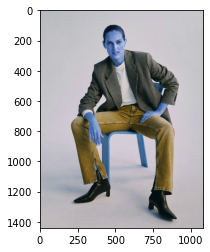

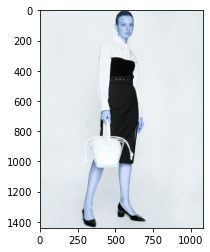

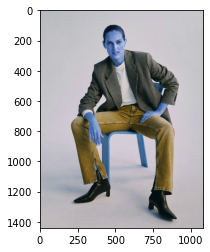

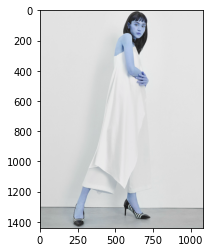

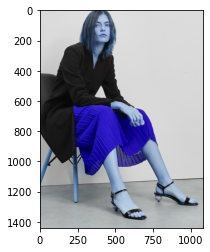

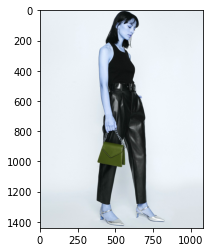

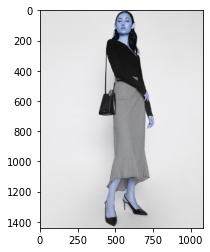

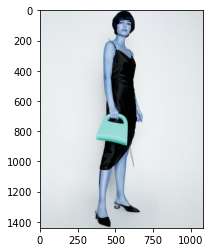

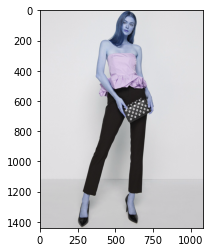

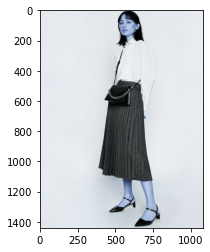

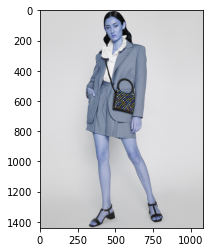

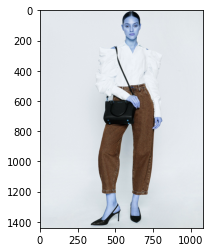

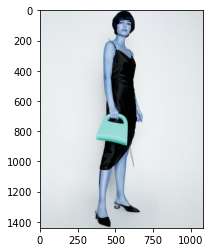

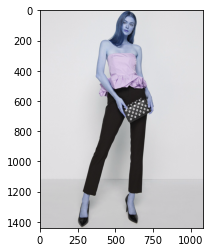

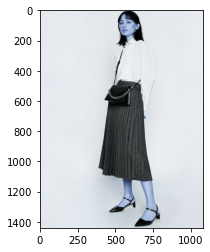

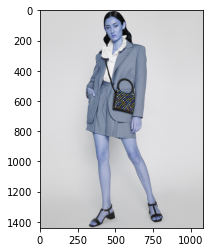

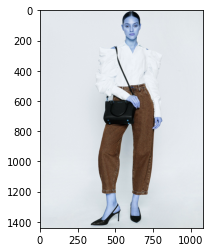

In [44]:
for i in women_heels:
    image = cv.imread(i)
    plt.imshow(image)
    plt.show()

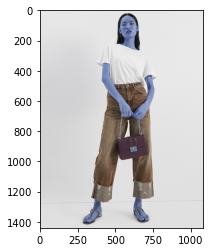

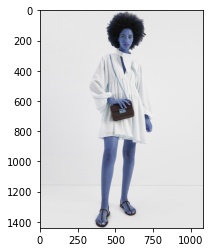

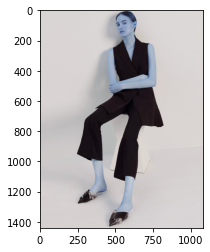

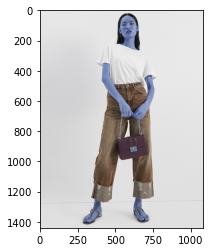

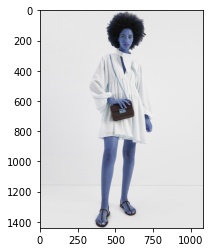

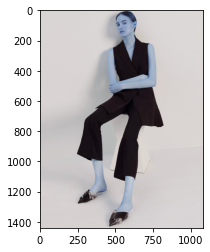

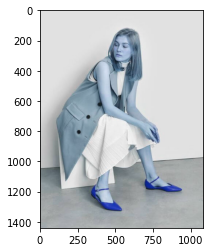

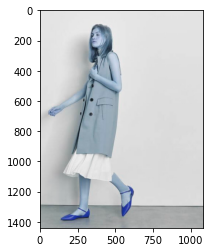

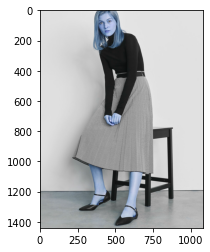

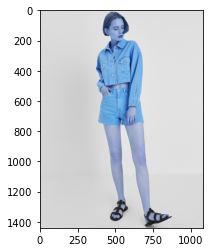

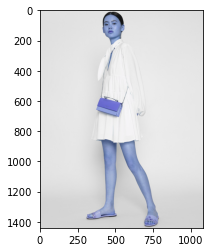

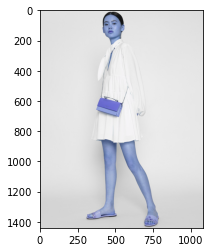

In [45]:
for i in women_flats:
    image = cv.imread(i)
    plt.imshow(image)
    plt.show()

In [38]:
print('women boots full image : {}'.format(len(boot_path)))
print('women causual shoes full image : {}'.format(len(women_casual_shoes)))
print('women flats full image : {}'.format(len(women_flats)))
print('women heels full image : {}'.format(len(women_heels)))
print('women jean juggings full image : {}'.format(len(women_jeans_jeggings)))
print('women shirts top tees full image : {}'.format(len(women_shirts_tops_tees)))
print('women shorts skirts full image : {}'.format(len(women_shorts_skirts)))
print('women trousers full image : {}'.format(len(women_trousers)))


women boots full image : 4
women causual shoes full image : 0
women flats full image : 12
women heels full image : 26
women jean juggings full image : 525
women shirts top tees full image : 2920
women shorts skirts full image : 652
women trousers full image : 2354


### EDA

In [51]:
size_of_full_path = [len(boot_path),len(women_casual_shoes),len(women_flats),len(women_heels),len(women_jeans_jeggings),len(women_shirts_tops_tees),len(women_shorts_skirts),len(women_trousers)]

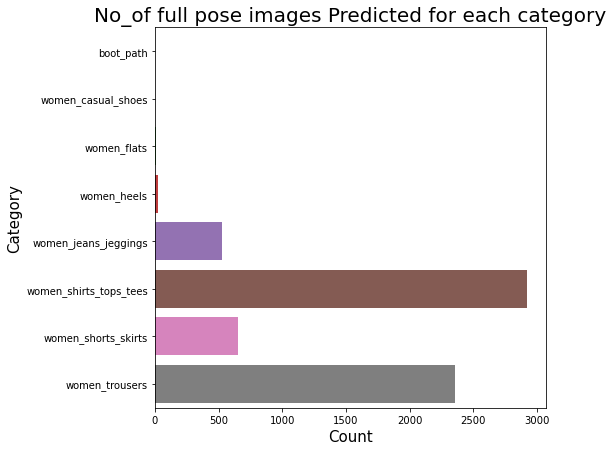

In [58]:
plt.figure(figsize=(7,7))
sn.barplot(size_of_full_path,
           ['boot_path','women_casual_shoes','women_flats','women_heels','women_jeans_jeggings',
            'women_shirts_tops_tees','women_shorts_skirts','women_trousers'])
plt.title('No_of full pose images Predicted for each category',fontsize=20)
plt.xlabel('Count',fontsize=15)
plt.ylabel('Category',fontsize=15)
plt.show()

In [67]:
start=time.time()
for i in women_shirts_tops_tees[:10]:
    print(final(i))
end=time.time()
print(end-start)

True
True
True
True
True
True
True
True
True
True
1.5412702560424805


<p> The time taken to predict wheather it is full pose image or not for 10 images is 1.54 seconds only for this model so the time taken for 1 image is just 100 ms approximately on my laptop with i7-gen, 8gb RAM, No GPU<pr>